In [1]:
## Imports
# import os
from pathlib import Path
# import shutil
import warnings
import opendatasets as od
from typing import Optional, Callable, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import torch
# import torchvision
from torch.utils.data import random_split
from torchvision.datasets.vision import VisionDataset

In [2]:
## Simulate the args like in the `main_*.py` files
class ARGS:
    #federated arguments
    # epochs:int = 1000         # rounds of training
    epochs:int = 10           # rounds of training
    num_users:int = 100       # number of users: K
    shard_per_user:int = 2    # classes per user
    frac:float = 0.1          # the fraction of clients: C
    local_ep:int = 1          # the number of local epochs: E
    local_bs:int = 10         # local batch size: B
    bs:int = 128              # test batch size
    lr:float = 0.01           # learning rate
    # results_save:str = "run1"
    momentum:float = 0.5      # SGD momentum (default: 0.5)
    # gpu:int = 0
    split:str = "user"        # train-test split type, user or sample
    # grad_norm:str           # use_gradnorm_avging
    local_ep_pretrain:int = 0 # the number of pretrain local ep
    lr_decay:float = 1.0      # learning rate decay per round

    # model arguments
    model:str = "cnn"          # model name
    kernel_num:int = 9         # number of each kind of kernel
    kernel_sizes:str = "3,4,5" # comma-separated kernel size to use for convolution
    norm:str = "batch_norm"    # batch_norm, layer_norm, or None
    num_filters:int = 32       # number of filters for conv nets
    max_pool:str = True        # whether use max pooling rather than strided convolutions
    num_layers_keep:int = 1    # number layers to keep
    
    # other arguments
    dataset:str = "coba"      # name of dataset
    log_level:str = "info"    # level of logger
    iid:bool = True           # "store_true" #whether iid or not
    num_classes:int = 14      # number of classes
    num_channels:int = 3      # number of channels of images RGB
    gpu:int = 0               # GPU ID, -1 for CPU
    stopping_rounds:int = 10  # rounds of early stopping
    verbose:bool = True       # "store_true"
    print_freq:int = 100      # print loss frequency during training
    seed:int = 1              # random seed (default:1)
    test_freq:int = 1         # how often to test on val set
    load_fed:str = ""         # define pretrained federated model path
    results_save:str = "run1" # define fed results save folder
    start_saving:int = 0      # when to start saving models


args = ARGS()
args.num_users

100

In [3]:
from utils.coba_dataset import COBA

## Initialize CobaDataset
coba_dataset = COBA(root="data/coba", download=True)

In [4]:
## Create training and testing data -- method 1
train_size = int(0.8 * len(coba_dataset))
test_size = len(coba_dataset) - train_size
train_dataset, test_dataset = random_split(dataset=coba_dataset, lengths=[train_size, test_size])

In [5]:
len(train_dataset.indices)
# label.argmax()
# label_encodings[label.argmax().item()]
# print(f"Label: {label_encodings[label.argmax().item()]}")
# plt.imshow(img)

7046

Label: airplane


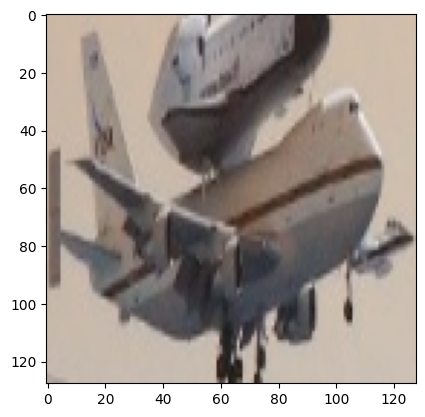

In [6]:
## Plot random train sample
example_image = coba_dataset[np.random.choice(train_dataset.indices, 1).item()]
img, label = example_image
label_encodings = train_dataset.dataset.class_to_idx

print(f"Label: {label_encodings[label.argmax().item()]}")
plt.imshow(img)

In [7]:
## The random split works!
dups = 0
for index in test_dataset.indices:
    if index in train_dataset.indices:
        dups += 1
print(dups)        

0


In [8]:
from utils.sampling import iid

In [9]:
dict_users_train = iid(dataset=train_dataset.dataset, args=args)
for user,d in dict_users_train.items():
    print(f"user:{user}\t\t len:{len(d)}")

user:0		 len:88
user:1		 len:88
user:2		 len:88
user:3		 len:88
user:4		 len:88
user:5		 len:88
user:6		 len:88
user:7		 len:88
user:8		 len:88
user:9		 len:88
user:10		 len:88
user:11		 len:88
user:12		 len:88
user:13		 len:88
user:14		 len:88
user:15		 len:88
user:16		 len:88
user:17		 len:88
user:18		 len:88
user:19		 len:88
user:20		 len:88
user:21		 len:88
user:22		 len:88
user:23		 len:88
user:24		 len:88
user:25		 len:88
user:26		 len:88
user:27		 len:88
user:28		 len:88
user:29		 len:88
user:30		 len:88
user:31		 len:88
user:32		 len:88
user:33		 len:88
user:34		 len:88
user:35		 len:88
user:36		 len:88
user:37		 len:88
user:38		 len:88
user:39		 len:88
user:40		 len:88
user:41		 len:88
user:42		 len:88
user:43		 len:88
user:44		 len:88
user:45		 len:88
user:46		 len:88
user:47		 len:88
user:48		 len:88
user:49		 len:88
user:50		 len:88
user:51		 len:88
user:52		 len:88
user:53		 len:88
user:54		 len:88
user:55		 len:88
user:56		 len:88
user:57		 len:88
user:58		 len:88
user:59

In [10]:
## Try noniid example
import random
from utils.sampling import noniid

In [11]:
dict_users_train, rand_set_all = noniid(dataset=train_dataset.dataset, args=args)
for user,d in dict_users_train.items():
    print(f"user:{user}\t\t len:{len(d)}")

[2024-01-10 03:19:12,119] sampling.py :: WARNING  :: ValueError: cannot reshape array of size 196 into shape (100,newaxis). Attempting to reshape...
[2024-01-10 03:19:12,120] sampling.py :: INFO     :: New rand_set_all.shape: (98, 2)


user:0		 len:271
user:1		 len:271
user:2		 len:94
user:3		 len:72
user:4		 len:119
user:5		 len:38
user:6		 len:40
user:7		 len:27
user:8		 len:88
user:9		 len:36
user:10		 len:65
user:11		 len:48
user:12		 len:87
user:13		 len:93
user:14		 len:70
user:15		 len:65
user:16		 len:61
user:17		 len:40
user:18		 len:87
user:19		 len:42
user:20		 len:116
user:21		 len:66
user:22		 len:65
user:23		 len:63
user:24		 len:72
user:25		 len:62
user:26		 len:88
user:27		 len:65
user:28		 len:115
user:29		 len:115
user:30		 len:40
user:31		 len:96
user:32		 len:63
user:33		 len:63
user:34		 len:269
user:35		 len:48
user:36		 len:214
user:37		 len:96
user:38		 len:58
user:39		 len:92
user:40		 len:70
user:41		 len:65
user:42		 len:41
user:43		 len:93
user:44		 len:125
user:45		 len:95
user:46		 len:38
user:47		 len:48
user:48		 len:73
user:49		 len:42
user:50		 len:48
user:51		 len:59
user:52		 len:115
user:53		 len:63
user:54		 len:210
user:55		 len:39
user:56		 len:56
user:57		 len:97
user:58		 len

In [12]:
args.num_users

98

In [13]:
coba_dataset.class_to_idx

{0: 'airplane',
 1: 'ambulance',
 2: 'briefcase',
 3: 'cannon',
 4: 'car',
 5: 'civilian',
 6: 'dagger',
 7: 'dog',
 8: 'handgun',
 9: 'missilerocket',
 10: 'rifle',
 11: 'soldier',
 12: 'tank',
 13: 'truck'}

In [14]:
import copy
import pickle
import numpy as np
import pandas as pd
import torch

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import LocalUpdate
from models.test import test_img
import os

In [15]:
args.device = torch.device(
        "cuda:{}".format(args.gpu)
        if torch.cuda.is_available() and args.gpu != -1
        else "cpu"
)
args.device

device(type='cuda', index=0)

In [16]:
from utils.options import get_logger
from logging import Logger

filename: str = "iobt_coba_data_viewer"
logger: Logger = get_logger(args=args, filename=filename)

logger.log(level=logger.level, msg=f"Log level: {args.log_level.upper()}")

args.device = torch.device(
    f"cuda:{args.gpu}" if torch.cuda.is_available() and args.gpu != -1 else "cpu"
)

dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

if args.dataset == "coba":
    dataset_train, dataset_test = dataset_train.dataset, dataset_test.dataset

logger.debug("%s dataset loaded", args.dataset.upper())

base_dir: Path = Path(
    "save",
    args.dataset,
    f"{args.model}_iid{args.iid}_num{args.num_users}_C{args.frac}_le{args.local_ep}",
    f"shard{args.shard_per_user}",
)

run_num: int = int(args.results_save[-1])

for file in base_dir.glob(pattern="*"):
    if args.results_save[:-1] in file.as_posix():
        run_num += 1
    else:
        break

args.results_save = f"{args.results_save[:-1]}{run_num}"

base_dir = Path(base_dir, args.results_save)

logger.info("Base save directory: %s", base_dir)

if not Path(base_dir, "fed").exists():
    Path(base_dir, "fed").mkdir(exist_ok=True, parents=True)

dict_save_path: Path = Path(base_dir, "dict_users.pkl")
with open(dict_save_path, "wb") as handle:
    pickle.dump((dict_users_train, dict_users_test), handle)

# build model
logger.debug("Building Model")
net_glob = get_model(args)
logger.debug("Model built\n%s", net_glob)

logger.debug("Setting model to training mode")
net_glob.train()

# training
results_save_path: Path = Path(base_dir, "fed/results.csv")

loss_train = []
net_best = None
best_loss = None
best_acc = None
best_epoch = None

w_glob = None
m = max(int(args.frac * args.num_users), 1)

lr: float = args.lr
results: list = []

logger.debug("Starting training loop")
for _iter in range(args.epochs):
# for _iter in range(1):
    loss_locals = []
    # w_glob = None
    # m = max(int(args.frac * args.num_users), 1)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    logger.info("Round %3d, lr: %.3f, %s", _iter, lr, idxs_users)

    for idx in idxs_users:
        logger.debug("User %i local training", idx)
        local = LocalUpdate(
            args=args, dataset=dataset_train, idxs=dict_users_train[idx]
        )
        logger.debug("\tcreating net_local")
        net_local = copy.deepcopy(net_glob)
        logger.debug("\tnet_local created")

        logger.debug("\ttraining to get w_local and loss")
        w_local, loss = local.train(net=net_local.to(args.device))
        logger.debug("\ttraining completed")

        logger.debug("\tadding loss to loss_locals")
        loss_locals.append(copy.deepcopy(loss))

        if w_glob is None:
            logger.debug("\tcreated w_glob (during User %i)", idx)
            w_glob = copy.deepcopy(w_local)
        else:
            logger.debug("\tadding w_local[k] to each key k in w_glob[k]")
            for k in w_glob.keys():
                w_glob[k] += w_local[k]

    logger.debug("Modifying lr")
    lr *= args.lr_decay

    # update global weights
    logger.debug("Updating global weights")
    for k in w_glob.keys():
        w_glob[k] = torch.div(w_glob[k], m)

    # copy weight to net_glob
    logger.debug("Copying weights")
    net_glob.load_state_dict(w_glob)

    # print loss
    logger.debug("Calculating Loss")
    loss_avg = sum(loss_locals) / len(loss_locals)
    loss_train.append(loss_avg)

    if (_iter + 1) % args.test_freq == 0:
        logger.debug("Evaluating net_glob")
        net_glob.eval()

        # pylint: disable=unbalanced-tuple-unpacking
        logger.debug("Calculating acc_test and loss_test")
        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        logger.info(
            # "\tRound %3d, Avg loss %.3f, Test loss %.6f, Test accuracy: %.2f",
            "\tAvg loss %.3f, Test loss %.6f, Test accuracy: %.2f",
            # _iter,
            loss_avg,
            loss_test,
            acc_test,
        )

        if best_acc is None or acc_test > best_acc:
            net_best = copy.deepcopy(net_glob)
            best_acc = acc_test
            best_epoch = _iter

        # if (iter + 1) > args.start_saving:
        #     model_save_path = os.path.join(base_dir, 'fed/model_{}.pt'.format(_iter + 1))
        #     torch.save(net_glob.state_dict(), model_save_path)

        results.append(np.array([_iter, loss_avg, loss_test, acc_test, best_acc]))
        final_results = np.array(results)
        final_results = pd.DataFrame(
            final_results,
            columns=["epoch", "loss_avg", "loss_test", "acc_test", "best_acc"],
        )
        final_results.to_csv(results_save_path, index=False)

    if (_iter + 1) % 50 == 0:
        best_save_path: Path = Path(base_dir, f"fed/best_{_iter+1}.pt")
        model_save_path: Path = Path(base_dir, f"fed/model_{_iter+1}.pt")

        if args.device.type != "cpu":
            torch.save(
                net_best.to(torch.device("cpu")).state_dict(), best_save_path
            )
            torch.save(
                net_glob.to(torch.device("cpu")).state_dict(), model_save_path
            )
        else:
            torch.save(net_best.state_dict(), best_save_path)
            torch.save(net_glob.state_dict(), model_save_path)

logger.info("Best model, iter: %i, acc: %f", best_epoch, best_acc)

[2024-01-10 03:19:12,829] 2642810593.py :: INFO     :: Log level: INFO
[2024-01-10 03:19:13,454] 2642810593.py :: INFO     :: Base save directory: save/coba/cnn_iidTrue_num98_C0.1_le1/shard2/run19
[2024-01-10 03:19:13,757] 2642810593.py :: INFO     :: Round   0, lr: 0.010, [58 71 25 83 11 18  9 60 81]


CNNCoba(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=65536, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=14, bias=True)
    (7): LogSoftmax(dim=1)
  )
)


[2024-01-10 03:19:15,999] test.py :: INFO     :: Test set: Average loss: 2.5754, Accuracy: 2748/8808 (31.20%)
[2024-01-10 03:19:16,000] 2642810593.py :: INFO     :: 	Avg loss 3.706, Test loss 2.575429, Test accuracy: 31.20
[2024-01-10 03:19:16,006] 2642810593.py :: INFO     :: Round   1, lr: 0.010, [36 55 45 47  8 42 17 69 79]
[2024-01-10 03:19:17,628] test.py :: INFO     :: Test set: Average loss: 2.4791, Accuracy: 2748/8808 (31.20%)
[2024-01-10 03:19:17,628] test.py :: INFO     :: Test set: Average loss: 2.4791, Accuracy: 2748/8808 (31.20%)
[2024-01-10 03:19:17,630] 2642810593.py :: INFO     :: 	Avg loss 2.533, Test loss 2.479080, Test accuracy: 31.20
[2024-01-10 03:19:17,632] 2642810593.py :: INFO     :: Round   2, lr: 0.010, [51 52 19 31 24 34 88 54 43]
[2024-01-10 03:19:19,280] test.py :: INFO     :: Test set: Average loss: 2.4044, Accuracy: 2748/8808 (31.20%)
[2024-01-10 03:19:19,280] test.py :: INFO     :: Test set: Average loss: 2.4044, Accuracy: 2748/8808 (31.20%)
[2024-01-10 

In [17]:
# loss_func = torch.nn.CrossEntropyLoss()

In [18]:
## Troubleshooting with Shape errors
# image,label = coba_dataset[0]
# print(image.shape)
# image = image.permute(2,0,1)
# print(image.shape)

In [19]:
imgs, labels = train_dataset.dataset[:]

In [20]:
labels

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [21]:
torch.tensor(list(map(torch.argmax,labels)))

tensor([5, 5, 6,  ..., 0, 2, 7])

In [22]:
args.device

device(type='cuda', index=0)

In [23]:
args.device.type

'cuda'